In [23]:
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class OxfordBatteryDatasetBuilder:
    def __init__(self, rated_capacity=0.74, interpolation_points=1000,
                 interpolation_targets={'q': True, 'i': True, 't': True},
                 mode='spline'):
        self.rated_capacity = rated_capacity
        self.interpolation_points = interpolation_points
        self.interpolation_targets = interpolation_targets
        self.v_grid = np.linspace(3.0, 4.2, interpolation_points)
        self.mode = mode  # 'spline' or 'sample'

    def find_all_mat_files(self, base_folder):
        base_path = Path(base_folder)
        return list(base_path.glob("*.mat"))

    def load_mat_file(self, mat_obj):
        def _check_keys(obj):
            if isinstance(obj, scipy.io.matlab.mat_struct):
                return _todict(obj)
            elif isinstance(obj, np.ndarray):
                return [_check_keys(el) for el in obj]
            else:
                return obj

        def _todict(matobj):
            d = {}
            for fieldname in matobj._fieldnames:
                d[fieldname] = _check_keys(getattr(matobj, fieldname))
            return d

        return {key: _check_keys(val) for key, val in mat_obj.items() if not key.startswith("__")}

    def validate_all_against_voltage_time(self, t_v, **kwargs):
        """
        Validates that all provided signals are time-aligned with voltage time vector.
        
        Parameters:
            t_v (np.ndarray): Time vector for voltage
            **kwargs: Dictionary of signal name → time vector (e.g. t_q=t_q, t_i=t_i, ...)
        
        Returns:
            bool: True if all signals are aligned with t_v, False otherwise
        """
        all_good = True
        for name, t_arr in kwargs.items():
            if len(t_arr) != len(t_v):
                print(f"[Mismatch] {name}: len={len(t_arr)} vs voltage len={len(t_v)}")
                all_good = False
                continue
            diff = np.abs(t_arr - t_v)
            if np.any(diff > 1e-3):
                print(f"[Mismatch] {name}: max time diff = {np.max(diff):.6f}s")
                all_good = False
        return all_good

    def compute_derivative_stats(self, Y, T):
        T = np.array(T, dtype=float)
        Y = np.array(Y)

        if len(Y) != len(T) or len(Y) < 2:
            return {"min": np.nan, "max": np.nan, "mean": np.nan, "std": np.nan}

        # Remove duplicate timestamps (keep first)
        valid = np.diff(T, prepend=-np.inf) > 0
        T, Y = T[valid], Y[valid]

        if len(T) < 2:
            return {"min": np.nan, "max": np.nan, "mean": np.nan, "std": np.nan}

        dYdt = np.gradient(Y, T)
        return {
            "min": np.min(dYdt),
            "max": np.max(dYdt),
            "mean": np.mean(dYdt),
            "std": np.std(dYdt)
        }
    
    def audit_duplicate_removal_safety(self, df, signal="voltage_raw", threshold=1e-5):
        """
        Audit each cycle to determine whether removing duplicates significantly affects dY/dt.
        Returns a DataFrame with the 'safe_to_remove' flag per cycle.
        """
        import numpy as np
        import pandas as pd

        results = []

        for _, row in df.iterrows():
            cell_id = row["cell_id"]
            cycle_index = row["cycle_index"]
            T = np.array(row["time_raw"])
            Y = np.array(row[signal])

            # Skip mismatched or malformed rows
            if len(T) != len(Y) or len(T) < 3:
                results.append((cell_id, cycle_index, np.nan, np.nan, np.nan, False))
                continue

            # Remove duplicates
            mask = np.diff(T, prepend=-np.inf) > 0
            T_clean, Y_clean = T[mask], Y[mask]

            # Average duplicates
            df_avg = pd.DataFrame({'T': T, 'Y': Y}).groupby('T', as_index=False).mean()
            T_avg, Y_avg = df_avg['T'].values, df_avg['Y'].values

            # Compute derivatives
            try:
                d_clean = np.gradient(Y_clean, T_clean)
                d_avg = np.gradient(Y_avg, T_avg)

                min_len = min(len(d_clean), len(d_avg))
                diff = np.abs(d_clean[:min_len] - d_avg[:min_len])
                mean_abs_diff = np.mean(diff)

                # Flag: is removing duplicates safe?
                is_safe = mean_abs_diff < threshold

                results.append((cell_id, cycle_index, mean_abs_diff, d_clean.std(), d_avg.std(), is_safe))

            except Exception:
                results.append((cell_id, cycle_index, np.nan, np.nan, np.nan, False))

        return pd.DataFrame(results, columns=[
            "cell_id", "cycle_index", "mean_abs_dYdt_diff", "std_dYdt_clean", "std_dYdt_avg", "safe_to_remove"
        ])

    def compute_current(self, Q_raw, T):
        if len(T) < 2 or len(Q_raw) != len(T):
            return None
        
        order = np.argsort(T)  # Align with T
        T_sorted = T[order]
        Q_sorted = Q_raw[order]

        Q_ah = -Q_sorted / 1000  # Convert from mAh to Ah
        dt = np.gradient(T_sorted)
        I = np.gradient(Q_ah) / dt  # Current in Amps

        return I, order

    def sample_signal(self, V, Y):
        if len(V) < 2 or len(Y) != len(V):
            return None
        idx = (V >= 3.0) & (V <= 4.2)
        V, Y = V[idx], Y[idx]
        order = np.argsort(V)
        V, Y = V[order], Y[order]
        return np.interp(self.v_grid, V, Y)

    def interpolate_signals(self, V, Q_raw, T, t): 
        I, t_order = self.compute_current(Q_raw, t)
        if I is None:
            return None

        # Align signals based on sorted time
        V_sorted = V[t_order]
        Q_sorted = -Q_raw[t_order] / 1000  # Ah
        T_sorted = T[t_order]
        I_sorted = I[t_order]
        I_raw = -I[t_order]

        # Mask and sort by voltage
        mask = (V_sorted >= 3.0) & (V_sorted <= 4.18)
        if np.count_nonzero(mask) < 10:
            return None

        V_masked = V_sorted[mask]
        sort_idx = np.argsort(V_masked)

        V_final = V_masked[sort_idx]
        Q_final = Q_sorted[mask][sort_idx]
        I_final = I_sorted[mask][sort_idx]
        T_final = T_sorted[mask][sort_idx]

        result = {}

        if self.mode == 'sample':
            if self.interpolation_targets.get('q'): result['q'] = self.sample_signal(V_final, Q_final)
            if self.interpolation_targets.get('i'): result['i'] = self.sample_signal(V_final, I_final)
            if self.interpolation_targets.get('t'): result['t'] = self.sample_signal(V_final, T_final)
        elif self.mode == 'spline':
            def safe_spline(x, y, s=1e-2):
                if np.allclose(y, y[0], rtol=1e-4):
                    return np.full_like(self.v_grid, y[0])
                for _ in range(5):
                    tck = interpolate.splrep(x, y, s=s)
                    if not np.isnan(tck[1]).any():
                        return interpolate.splev(self.v_grid, tck)
                    s *= 10
                return np.full_like(self.v_grid, np.nan)

            if self.interpolation_targets.get('q'): result['q'] = safe_spline(V_final, Q_final)
            if self.interpolation_targets.get('i'): result['i'] = safe_spline(V_final, I_final)
            if self.interpolation_targets.get('t'): result['t'] = safe_spline(V_final, T_final)
        else:
            raise ValueError("Unknown interpolation mode. Use 'spline' or 'sample'.")

        if any(val is None or np.isnan(val).all() for val in result.values()):
            print("Interpolation failed")
            return None

        result['I'] = I_raw  # full aligned current, not interpolated
        return result

    def process_all_files(self, base_folder):
        mat_files = self.find_all_mat_files(base_folder)
        if not mat_files:
            print("No .mat files found.")
            return None

        all_rows = []
        for mat_file in mat_files:
            battery_id = mat_file.stem
            print(f"Processing {battery_id}...")
            mat = scipy.io.loadmat(mat_file, struct_as_record=False, squeeze_me=True)
            mat_dict = self.load_mat_file(mat)

            for cell_name, cell_data in mat_dict.items():
                if not isinstance(cell_data, dict):
                    continue
                for cycle_id, cycle_content in cell_data.items():
                    if not isinstance(cycle_content, dict) or "C1dc" not in cycle_content:
                        continue

                    dc_data = cycle_content["C1dc"]
                    try:
                        q = np.array(dc_data.get("q", []))
                        t_raw = np.array(dc_data.get("t", []))
                        v = np.array(dc_data.get("v", []))
                        T = np.array(dc_data.get("T", []))

                        if len(q) < 2 or not all(len(arr) == len(t_raw) for arr in [q, v, T]):
                            continue

                        t = (t_raw - t_raw[0]) * 86400
                        q_ah = abs(min(q)) / 1000
                        soh = q_ah / self.rated_capacity

                        # check time pair alignment
                        aligned = self.validate_all_against_voltage_time(
                            t_v=t,
                            t_q=t,
                            t_T=t,
                            t_cycle=t
                        )

                        if not aligned:
                            print(f"Signal misalignment detected in {cell_name} {cycle_id}")
                            continue                      

                        interp = self.interpolate_signals(v, q, T, t)
                        if interp is None:
                            continue

                        dqdt = self.compute_derivative_stats(-q / 1000, t)
                        dvdt = self.compute_derivative_stats(v, t)
                        didt = self.compute_derivative_stats(interp["I"], t)

                        row = {
                            "cell_id": cell_name,
                            "rated_capacity": self.rated_capacity,
                            "cycle_index": int(cycle_id.replace("cyc", "")),
                            "capacity": q_ah,
                            "soh": soh,
                            "voltage_raw": v.tolist(),
                            "current_raw": interp["I"].tolist(),
                            "charge_raw": (-q / 1000).tolist(),
                            "temperature_raw": T.tolist(),
                            "time_raw": t.tolist(),
                            "dqdt_min": dqdt["min"], "dqdt_max": dqdt["max"],
                            "dqdt_mean": dqdt["mean"], "dqdt_std": dqdt["std"],
                            "dvdt_min": dvdt["min"], "dvdt_max": dvdt["max"],
                            "dvdt_mean": dvdt["mean"], "dvdt_std": dvdt["std"],
                            "didt_min": didt["min"], "didt_max": didt["max"],
                            "didt_mean": didt["mean"], "didt_std": didt["std"],
                            **{f"q_interp_{i}": val for i, val in enumerate(interp["q"])} ,
                            **{f"i_interp_{i}": val for i, val in enumerate(interp["i"])} ,
                            **{f"t_interp_{i}": val for i, val in enumerate(interp["t"])}
                        }

                        all_rows.append(row)

                    except Exception as e:
                        print(f"Failed to process {cell_name} {cycle_id}: {e}")
                        continue

        if not all_rows:
            print("No valid data found.")
            return None

        return pd.DataFrame(all_rows)

    def plot_qit_from_dataframe(self, df, cell_id, cycle_index):
        row = df[(df['cell_id'] == cell_id) & (df['cycle_index'] == cycle_index)]
        if row.empty:
            print("Entry not found.")
            return

        q_vals = row.filter(like='q_interp_').values.flatten()
        i_vals = row.filter(like='i_interp_').values.flatten()
        t_vals = row.filter(like='t_interp_').values.flatten()

        V_raw = np.array(row['voltage_raw'].values[0])
        Q_raw = np.array(row['charge_raw'].values[0])
        t_raw = np.array(row['time_raw'].values[0])
        T_raw = np.array(row['temperature_raw'].values[0])

        dt = np.gradient(t_raw)
        I_raw = np.gradient(Q_raw) / dt

        idx = (V_raw >= 3.0) & (V_raw <= 4.2)
        V_raw, Q_raw, T_raw, I_raw = V_raw[idx], Q_raw[idx], T_raw[idx], I_raw[idx]

        order = np.argsort(V_raw)
        V_raw, Q_raw, T_raw, I_raw = V_raw[order], Q_raw[order], T_raw[order], I_raw[order]

        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        axs[0].plot(V_raw, Q_raw, label="Raw Q", linestyle='-')
        axs[0].plot(self.v_grid, q_vals, label="Interpolated Q", linestyle='--')
        axs[0].set_title("Q vs V")
        axs[0].set_ylabel("Charge (Ah)")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(V_raw, I_raw, label="Raw I", linestyle='-')
        axs[1].plot(self.v_grid, i_vals, label="Interpolated I", linestyle='--')
        axs[1].set_title("I vs V")
        axs[1].set_ylabel("Current (A)")
        axs[1].legend()
        axs[1].grid(True)

        axs[2].plot(V_raw, T_raw, label="Raw T", linestyle='-')
        axs[2].plot(self.v_grid, t_vals, label="Interpolated T", linestyle='--')
        axs[2].set_title("T vs V")
        axs[2].set_ylabel("Temperature (°C)")
        axs[2].legend()
        axs[2].grid(True)

        for ax in axs:
            ax.set_xlabel("Voltage (V)")

        fig.suptitle(f"Interpolation Plots for {cell_id} — Cycle Index {cycle_index}")
        plt.tight_layout()
        plt.show()

    def plot_multiple_cycles(self, df, cell_id, cycle_idx, signal='q'):
        plt.figure(figsize=(8, 5))
        for cycle_index in cycle_idx:
            row = df[(df['cell_id'] == cell_id) & (df['cycle_index'] == cycle_index)]
            if row.empty:
                print(f"Row not found for {cell_id} Cycle {cycle_index}")
                continue
            y_vals = row[[f'{signal}_interp_{i}' for i in range(self.interpolation_points)]].values.flatten()
            plt.plot(self.v_grid, y_vals, label=f'Cycle {cycle_index}')

        plt.title(f'{signal.upper()} vs Voltage for {cell_id}')
        plt.xlabel('Voltage (V)')
        plt.ylabel(signal.upper())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def plot_signals_and_derivatives_vs_time(self, df, cell_id, cycle_index):
        row = df[(df["cell_id"] == cell_id) & (df["cycle_index"] == cycle_index)]
        if row.empty:
            print("Entry not found.")
            return

        T = np.array(row["time_raw"].values[0])
        Q = np.array(row["charge_raw"].values[0])
        V = np.array(row["voltage_raw"].values[0])
        I = np.array(row["current_raw"].values[0])

        # Sort by time
        order = np.argsort(T)
        T, Q, V, I = T[order], Q[order], V[order], I[order]

        dQdt = np.gradient(Q, T)
        dVdt = np.gradient(V, T)
        dIdt = np.gradient(I, T)

        fig, axs = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

        # Left column: raw signals
        axs[0, 0].plot(T, Q, label="Q (Ah)")
        axs[0, 0].set_ylabel("Charge (Ah)")
        axs[0, 0].legend()
        axs[0, 0].grid(True)

        axs[1, 0].plot(T, V, label="V (V)", color="orange")
        axs[1, 0].set_ylabel("Voltage (V)")
        axs[1, 0].legend()
        axs[1, 0].grid(True)

        axs[2, 0].plot(T, I, label="I (A)", color="green")
        axs[2, 0].set_ylabel("Current (A)")
        axs[2, 0].legend()
        axs[2, 0].grid(True)

        # Right column: derivatives
        axs[0, 1].plot(T, dQdt, label="dQ/dt", color="blue")
        axs[0, 1].set_ylabel("dQ/dt (A)")
        axs[0, 1].legend()
        axs[0, 1].grid(True)

        axs[1, 1].plot(T, dVdt, label="dV/dt", color="orange")
        axs[1, 1].set_ylabel("dV/dt (V/s)")
        axs[1, 1].legend()
        axs[1, 1].grid(True)

        axs[2, 1].plot(T, dIdt, label="dI/dt", color="green")
        axs[2, 1].set_ylabel("dI/dt (A/s)")
        axs[2, 1].legend()
        axs[2, 1].grid(True)

    def plot_signals_and_derivatives_plotly(self, df, cell_id, cycle_index):
        row = df[(df["cell_id"] == cell_id) & (df["cycle_index"] == cycle_index)]
        if row.empty:
            print("Entry not found.")
            return

        T = np.array(row["time_raw"].values[0])
        Q = np.array(row["charge_raw"].values[0])
        V = np.array(row["voltage_raw"].values[0])
        I = np.array(row["current_raw"].values[0])

        order = np.argsort(T)
        T, Q, V, I = T[order], Q[order], V[order], I[order]

        dQdt = np.gradient(Q, T)
        dVdt = np.gradient(V, T)
        dIdt = np.gradient(I, T)

        fig = make_subplots(rows=3, cols=2, shared_xaxes=True,
                            subplot_titles=("Q (Ah)", "dQ/dt (A)",
                                            "V (V)", "dV/dt (V/s)",
                                            "I (A)", "dI/dt (A/s)"))

        fig.add_trace(go.Scatter(x=T, y=Q, mode='lines', name='Q (Ah)'), row=1, col=1)
        fig.add_trace(go.Scatter(x=T, y=dQdt, mode='lines', name='dQ/dt (A)', line=dict(color='blue')), row=1, col=2)

        fig.add_trace(go.Scatter(x=T, y=V, mode='lines', name='V (V)', line=dict(color='orange')), row=2, col=1)
        fig.add_trace(go.Scatter(x=T, y=dVdt, mode='lines', name='dV/dt (V/s)', line=dict(color='orange')), row=2, col=2)

        fig.add_trace(go.Scatter(x=T, y=I, mode='lines', name='I (A)', line=dict(color='green')), row=3, col=1)
        fig.add_trace(go.Scatter(x=T, y=dIdt, mode='lines', name='dI/dt (A/s)', line=dict(color='green')), row=3, col=2)

        fig.update_layout(height=900, width=1150,
                        title_text=f"Interactive Signal and Derivative Plots for {cell_id} — Cycle {cycle_index}",
                        showlegend=False)

        
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=1, col=1)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=1, col=2)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=2, col=1)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=2, col=2)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=3, col=1)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=3, col=2)

        fig.show()

In [24]:
builder = OxfordBatteryDatasetBuilder(mode='spline')

In [14]:
df_oxford = builder.process_all_files("../Datasets/Oxford Battery Degradation Dataset 1")

Processing ExampleDC_C1...
Processing Oxford_Battery_Degradation_Dataset_1...


c:\Users\adien\anaconda3\Lib\site-packages\scipy\interpolate\_fitpack_py.py:304: RuntimeWarning:

The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)



In [15]:
df_oxford.head() 

,cell_id,rated_capacity,cycle_index,capacity,soh,voltage_raw,current_raw,charge_raw,temperature_raw,time_raw,...,t_interp_990,t_interp_991,t_interp_992,t_interp_993,t_interp_994,t_interp_995,t_interp_996,t_interp_997,t_interp_998,t_interp_999
0,Cell1,0.74,0,0.739111,0.998799,"[4.1912351, 4.1757555, 4.1743121, 4.1726279, 4...","[-0.00019483238286871092, -0.00019989424989364...","[-0.0, 0.0001948313260934485, 0.00039978834191...","[40.026463, 40.051395, 39.988987, 39.976521, 3...","[0.0, 0.9999945759773254, 1.9999992102384567, ...",...,39.941300,39.938109,39.934909,39.931700,39.928481,39.925253,39.922016,39.918771,39.915517,39.912254
1,Cell1,0.74,100,0.730193,0.986747,"[4.1926785, 4.1765175, 4.1749935, 4.1737504, 4...","[-0.00019481358446271993, -0.00019987489377395...","[-0.0, 0.00019481252778942048, 0.0003997496296...","[39.964054, 39.8517, 39.876675, 39.914112, 39....","[0.0, 0.9999945759773254, 1.9999992102384567, ...",...,39.800985,39.797342,39.793680,39.790000,39.786303,39.782589,39.778856,39.775107,39.771340,39.767555
2,Cell1,0.74,200,0.725747,0.980739,"[4.1929593, 4.1769986, 4.1752744, 4.1739912, 4...","[-0.0001947946334525561, -0.000199859056617970...","[-0.0, 0.00019479553618175448, 0.0003997179553...","[39.914112, 39.901646, 39.876675, 39.901646, 3...","[0.0, 1.0000046342611313, 1.9999992102384567, ...",...,39.808931,39.805404,39.801858,39.798294,39.794712,39.791111,39.787492,39.783855,39.780200,39.776527
3,Cell1,0.74,300,0.722843,0.976815,"[4.192502, 4.1766214, 4.1748571, 4.1732931, 4....","[-0.0001947217497488367, -0.000199782814057140...","[-0.0, 0.000194722652140273, 0.000399565470333...","[39.926579, 39.876675, 39.976521, 39.901646, 3...","[0.0, 1.0000046342611313, 1.9999992102384567, ...",...,39.793669,39.789287,39.784871,39.780422,39.775940,39.771424,39.766874,39.762292,39.757676,39.753026
4,Cell1,0.74,400,0.718367,0.970766,"[4.1927824, 4.1767821, 4.1753383, 4.1738949, 4...","[-0.00019478819564740024, -0.00019984887569948...","[-0.0, 0.00019478713911181032, 0.0003996975935...","[39.876675, 39.926579, 39.926579, 39.864166, 3...","[0.0, 0.9999945759773254, 1.9999992102384567, ...",...,39.766253,39.761309,39.756324,39.751300,39.746235,39.741130,39.735985,39.730799,39.725573,39.720306


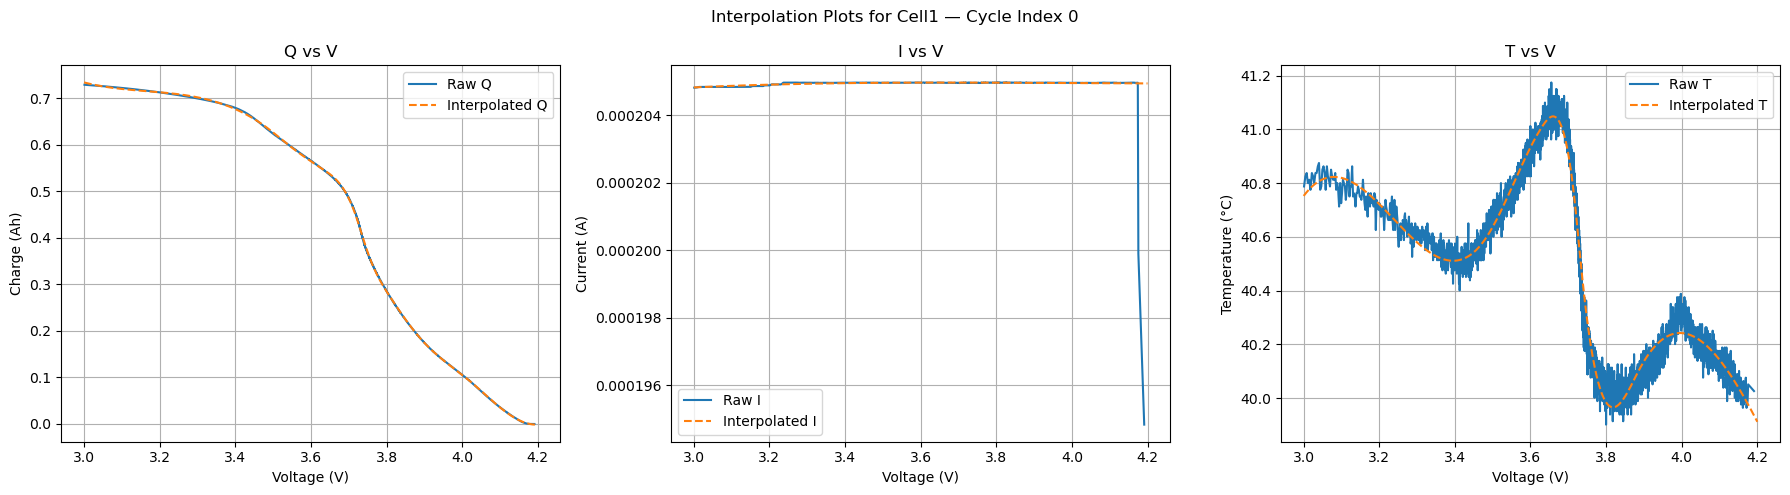

In [25]:
builder.plot_qit_from_dataframe(df_oxford, cell_id="Cell1", cycle_index=0)

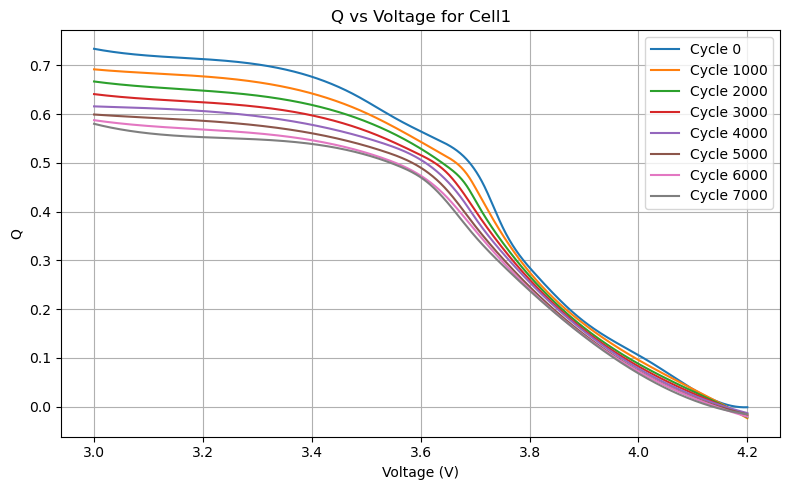

In [17]:
builder.plot_multiple_cycles(df_oxford, cell_id="Cell1", cycle_idx=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000], signal='q')


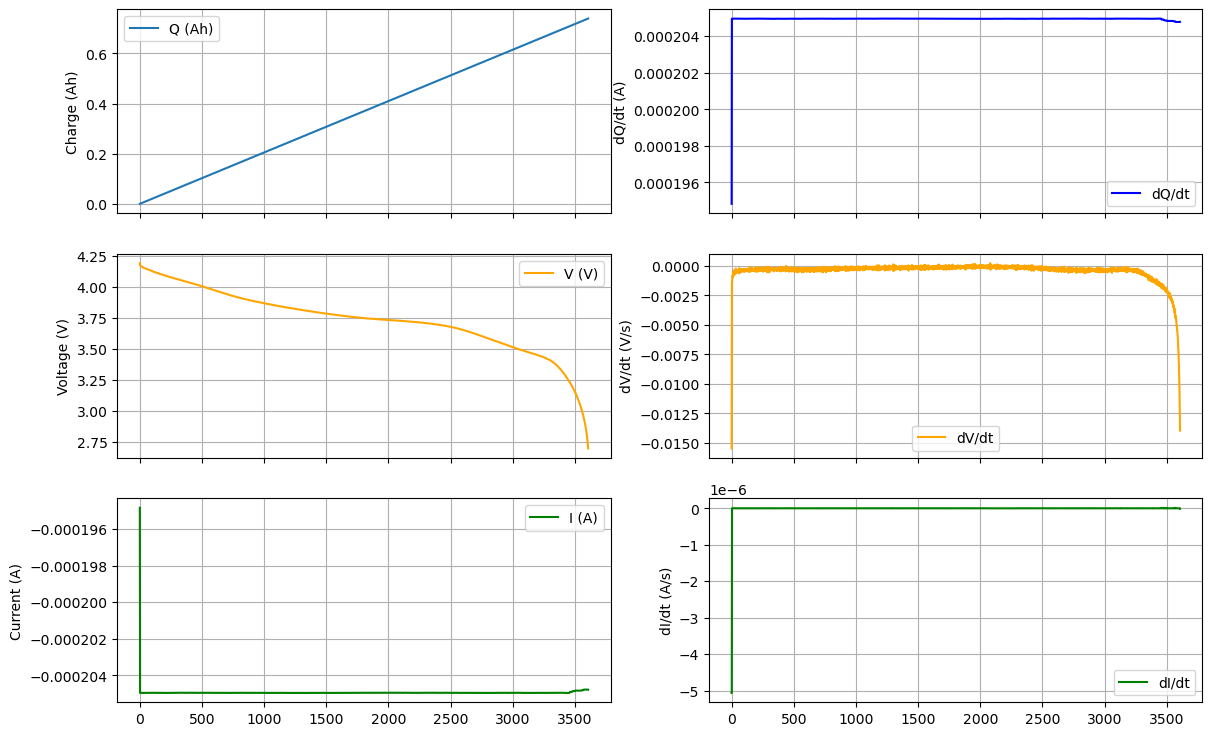

In [18]:
builder.plot_signals_and_derivatives_vs_time(df_oxford, cell_id="Cell1", cycle_index=0)

In [19]:
builder.plot_signals_and_derivatives_plotly(df_oxford, "Cell1", 0)

In [20]:
df_oxford.to_csv("../Datasets/oxford_Interp_flat.csv", index=False)

In [21]:
df_oxford.to_pickle("../Datasets/oxford_Interp_flat.pkl")

In [22]:
audit_all_df_oxford = builder.audit_duplicate_removal_safety(pd.read_pickle("../Datasets/oxford_Interp_flat.pkl"), signal="voltage_raw", threshold=1e-5)
audit_all_df_oxford['safe_to_remove'].unique()

array([ True])